In [30]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from mplsoccer.pitch import Pitch
import json
import pandas as pd
import re
from math import isnan, sqrt
from datetime import datetime, timedelta
from smoothing import performSmoothing, euclidianDistance

In [31]:
import csv

def read_partially(file_path, start_line, end_line):
    data = []  # List to store extracted CSV rows

    with open(file_path, 'r', newline='') as file:
        for line_num, row in enumerate(file):
            if line_num >= start_line and line_num <= end_line:
                # Append the row to data
                data.append(row)
            elif line_num > end_line:
                break  # Stop reading once end_line is reached

    return data
import csv

def read_csv_partially(file_path, start_line, end_line):
    data = []  # List to store extracted CSV rows

    with open(file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        for line_num, row in enumerate(reader):
            if line_num >= start_line and line_num <= end_line:
                # Append the row to data
                data.append(row)
            elif line_num > end_line:
                break  # Stop reading once end_line is reached

    return data

In [32]:
file_path_skillcorner = '../data/matches/vs FC Lugano/2023-12-06_StatsPerform_FC Lugano - FC fifa format Basel.txt'
lineup_path = '../data/matches/vs FC Lugano/2023-12-06_StatsPerform_FC Lugano - FC Basel_Match-Info.csv'
partialframes = read_partially(file_path_skillcorner, 0, 1500000)

lineup = read_csv_partially(lineup_path, 0, 33)
# targetIDSkillcorner = 7679
targetedPlayerID = 1050314
targetPositionsSkillcorner = []

def getTrajectories(teamID, lineup, partialframes):
    playerIDs = set()

    for player in list(filter(lambda player: int(player[1]) == 1, lineup)):
        playerIDs.add(str(player[9]))
    
    # print(playerIDs)
    # return None
    targetTrajs = {}
    for ID in playerIDs:
        targetTrajs[ID] = []

    for index, frame in enumerate(partialframes):
        f = re.split(':', frame)
        frameVars = re.split(';|,', f[0]) # 0 - system time; 1 - milliseconds of current half; 2 - current half
        frameVars = list(map(lambda x: int(x), frameVars))
        # print(frameVars)
        # return 
        playerPositions = f[1].split(';')
        for playerString in playerPositions:
            playerFrame = playerString.split(',') # 0 - object type; 1 - playerID; 2 - shirt Number, 3 - x; 4 - y
            if(len(playerFrame)) < 5:
                continue
            if(playerFrame[1] not in playerIDs):
                continue
            if targetTrajs[playerFrame[1]] == [] or int(targetTrajs[playerFrame[1]][-1][-1][-2]) != (int(frameVars[1]) - 40):
                targetTrajs[playerFrame[1]].append([])
            targetTrajs[playerFrame[1]][-1].append([float(playerFrame[3]), float(playerFrame[4]), -1, datetime.fromtimestamp(int(frameVars[1])/1000.0), int(frameVars[0]), int(frameVars[1]), int(frameVars[2])])
    return targetTrajs

targetTrajs = getTrajectories(1, lineup, partialframes)

In [33]:
def getSkillcornerTrajectories(teamName, lineup, partialframes):
    playerIDs = set()

    for player in list(filter(lambda player: player[1] == teamName, lineup[1:])):
        playerIDs.add(str(player[2]))

    targetTrajs = {}
    for ID in playerIDs:
        targetTrajs[ID] = []

    for index, playerFrame in enumerate(partialframes):

        if(playerFrame[4] not in playerIDs or playerFrame[8] == 'True'):
            continue

        if targetTrajs[playerFrame[4]] == [] or int(targetTrajs[playerFrame[4]][-1][-1][-1]) != (int(playerFrame[2]) - 1):
            targetTrajs[playerFrame[4]].append([])
        
        targetTrajs[playerFrame[4]][-1].append([float(playerFrame[5]), float(playerFrame[6]), -1, datetime.fromtimestamp(int(playerFrame[3])/1000.0), int(playerFrame[1]), int(playerFrame[3]), int(playerFrame[2])])
    return targetTrajs

file_path_skillcorner = '../data/matches/vs FC Lugano/Preprocessed Skillcorner data/1296476_tracking.csv'
lineup_path = '../data/matches/vs FC Lugano/Preprocessed Skillcorner data/1296476_lineup.csv'
partialframes = read_csv_partially(file_path_skillcorner, 0, 1500000)

lineup = read_csv_partially(lineup_path, 0, 33)
# targetIDSkillcorner = 7679
targetPositionsSkillcorner = []

skillcornerTrajs = getSkillcornerTrajectories("FC Basel", lineup, partialframes)


In [34]:
targetSkillcornerID = 59893
targetSkillcornerTrajs = skillcornerTrajs[str(targetSkillcornerID)]
# print(len(skillcornerTrajs))
# print(targetSkillcornerTrajs[0])
newTrajs = []
currentStatsPerformTrajIDX = 0
# print(len(targetSkillcornerTrajs))
for i, traj in enumerate(targetSkillcornerTrajs):
    newTraj = []
    start = traj[0][-2]
    stop = traj[-1][-2]
    # print(start)
    # print(stop)
    # print(f'First point in Skillcorner Traj ----------- {traj[0]}')
    for statsTraj in targetTrajs[str(targetedPlayerID)]:
        if statsTraj[-1][-2] < start or statsTraj[0][-2] > stop or int(statsTraj[0][-1]) != int(traj[0][-3]):
            continue
        else:
            for frame in statsTraj:
                if frame[-2] < start:
                    continue
                if frame[-2] > stop:
                    break
                # print(f'Frame in StatsPerform --- {frame}')
                if(frame[1] < 0 or frame[0] < 0):
                    print(frame)
                newTraj.append(frame)
    # print(len(newTraj))
    # print(len(traj))
    # if(i >= 6):
    #     break
    newTrajs.append(newTraj)
targetTrajs[str(targetedPlayerID)] = newTrajs

[38.497, -0.052, -1, datetime.datetime(1970, 1, 1, 1, 5, 52, 440000), 1701898552440, 352440, 2]
[38.56, -0.156, -1, datetime.datetime(1970, 1, 1, 1, 5, 52, 480000), 1701898552480, 352480, 2]
[38.622, -0.261, -1, datetime.datetime(1970, 1, 1, 1, 5, 52, 520000), 1701898552520, 352520, 2]
[38.683, -0.365, -1, datetime.datetime(1970, 1, 1, 1, 5, 52, 560000), 1701898552560, 352560, 2]
[38.743, -0.469, -1, datetime.datetime(1970, 1, 1, 1, 5, 52, 600000), 1701898552600, 352600, 2]
[38.803, -0.573, -1, datetime.datetime(1970, 1, 1, 1, 5, 52, 640000), 1701898552640, 352640, 2]
[38.862, -0.675, -1, datetime.datetime(1970, 1, 1, 1, 5, 52, 680000), 1701898552680, 352680, 2]
[38.92, -0.775, -1, datetime.datetime(1970, 1, 1, 1, 5, 52, 720000), 1701898552720, 352720, 2]
[38.978, -0.873, -1, datetime.datetime(1970, 1, 1, 1, 5, 52, 760000), 1701898552760, 352760, 2]
[39.035, -0.969, -1, datetime.datetime(1970, 1, 1, 1, 5, 52, 800000), 1701898552800, 352800, 2]
[39.091, -1.061, -1, datetime.datetime(197

In [35]:
print(len(newTrajs))
print(len(targetSkillcornerTrajs))
print(len(newTrajs[1]))
print(len(targetSkillcornerTrajs[1]))

255
255
5
3


In [36]:
# add for loop that starts here and smootens every trajectory in the traj list

its = [
    0, 
    2,
    5, 
    10, 
    # 50, 
    # 100, 
    # 150, 
    # 200
]

def extractSmoothDataFrames(targetTrajs, targetedPlayerID, its, freq=25):
    smoothDataFrames = []
    for it in its:
        playerSmoothDataFrames = pd.DataFrame()

        for player, trajs in targetTrajs.items():

            if player != str(targetedPlayerID):
                continue
            
            if player == []:
                continue

            for traj in trajs:
                if(len(traj) < 2):
                    continue

                new_traj = performSmoothing(datapoints=traj, iterations=it)
                new_traj = pd.DataFrame(new_traj)
                new_traj[5] = player
                traj = pd.DataFrame(traj)
                for idx, row in traj.iterrows():
                    if(isnan(row[4])):
                        print('nan')

                new_traj[4] = traj[4]
                new_traj[7] = traj[6]
                new_traj[6] = traj[5]

                playerSmoothDataFrames = pd.concat([playerSmoothDataFrames, new_traj], axis=0, ignore_index=True)
        
        playerSmoothDataFrames[4] = playerSmoothDataFrames[4].astype(int)
        playerSmoothDataFrames.columns = ['x', 'y', 'arc_length', 'time', 'systemTime', 'object_id', 'timestamp', 'half']

        playerSmoothDataFrames['speed'] = playerSmoothDataFrames['arc_length']*freq
        playerSmoothDataFrames.loc[playerSmoothDataFrames['arc_length'] == -1, 'speed'] = None

        playerSmoothDataFrames['systemTime'] = playerSmoothDataFrames['systemTime'].astype(int)
        playerSmoothDataFrames['timestamp'] = playerSmoothDataFrames['timestamp'].astype(int)
        playerSmoothDataFrames['half'] = playerSmoothDataFrames['half'].astype(int)
        playerSmoothDataFrames['x'] = playerSmoothDataFrames['x'].astype(float)
        playerSmoothDataFrames['y'] = playerSmoothDataFrames['y'].astype(float)

        smoothDataFrames.append(playerSmoothDataFrames.copy())
    return smoothDataFrames
    
smoothDataFrames = extractSmoothDataFrames(targetTrajs, targetedPlayerID, its)
originalDF = smoothDataFrames[0].drop(columns=['arc_length'])
smoothDataFrames.pop(0)
smoothDataFrames[0]

,x,y,arc_length,time,systemTime,object_id,timestamp,half,speed
0,65.059000,50.100000,-1.000000,1970-01-01 01:00:00.000,1701894600000,1050314,0,1,NaN
1,65.069736,50.128584,0.030373,1970-01-01 01:00:00.040,1701894600040,1050314,40,1,0.759337
2,65.080009,50.156849,0.029775,1970-01-01 01:00:00.080,1701894600080,1050314,80,1,0.744369
3,65.090017,50.184681,0.029379,1970-01-01 01:00:00.120,1701894600120,1050314,120,1,0.734477
4,65.100063,50.212205,0.029220,1970-01-01 01:00:00.160,1701894600160,1050314,160,1,0.730511
...,...,...,...,...,...,...,...,...,...
47199,18.220123,11.481428,0.082863,1970-01-01 01:50:06.520,1701901206520,1050314,3006520,2,2.071581
47200,18.296784,11.515445,0.084877,1970-01-01 01:50:06.560,1701901206560,1050314,3006560,2,2.121930
47201,18.374704,11.551185,0.086575,1970-01-01 01:50:06.600,1701901206600,1050314,3006600,2,2.164380
47202,18.453591,11.588490,0.087951,1970-01-01 01:50:06.640,1701901206640,1050314,3006640,2,2.198774


In [37]:
extraction = smoothDataFrames[2]
extraction

,x,y,arc_length,time,systemTime,object_id,timestamp,half,speed
0,65.059000,50.100000,-1.000000,1970-01-01 01:00:00.000,1701894600000,1050314,0,1,NaN
1,65.069488,50.128133,0.029988,1970-01-01 01:00:00.040,1701894600040,1050314,40,1,0.749690
2,65.079791,50.156189,0.029788,1970-01-01 01:00:00.080,1701894600080,1050314,80,1,0.744709
3,65.089931,50.184055,0.029518,1970-01-01 01:00:00.120,1701894600120,1050314,120,1,0.737952
4,65.099892,50.211689,0.029231,1970-01-01 01:00:00.160,1701894600160,1050314,160,1,0.730766
...,...,...,...,...,...,...,...,...,...
47199,18.223958,11.483024,0.082329,1970-01-01 01:50:06.520,1701901206520,1050314,3006520,2,2.058218
47200,18.300022,11.516871,0.084182,1970-01-01 01:50:06.560,1701901206560,1050314,3006560,2,2.104548
47201,18.377140,11.552385,0.085624,1970-01-01 01:50:06.600,1701901206600,1050314,3006600,2,2.140611
47202,18.454934,11.589253,0.086552,1970-01-01 01:50:06.640,1701901206640,1050314,3006640,2,2.163812


In [38]:
def extractMetrics(playerDF):
    maxSpeed = 0
    distanceCovered = 0
    metrics = {
        'maxSpeed': playerDF['speed'].max(),
        'distanceCovered': 0,
        'maximumSpeedSustained': 0,
        'sprintCount': 0,
    }

    # get sustained speed
    idxmax = playerDF['speed'].idxmax()
    l = idxmax
    h = l
    while (h < len(playerDF) and l >= 0):
        if(abs(playerDF.loc[h, 'speed'] - metrics['maxSpeed']) < 0.28):
            h += 1
        elif(abs(playerDF.loc[l, 'speed'] - metrics['maxSpeed']) < 0.28):
            l -= 1
        else:
            break
    metrics['maximumSpeedSustained'] = playerDF.loc[h, 'timestamp'] - playerDF.loc[l, 'timestamp']
    startOfSprintIDX = -1
    # handle unsmoothed data
    if("arc_length" not in playerDF.columns):
        for i, row in playerDF.iterrows():
            if(i == 0):
                continue
            if(row['timestamp'] == playerDF.loc[i-1, 'timestamp'] + 40):
                distanceCovered += euclidianDistance([row['x'], row['y']], [playerDF.loc[i-1, 'x'], playerDF.loc[i-1, 'y']])

            if(row['speed'] > 6.94):
                if(startOfSprintIDX == -1):
                    startOfSprintIDX = i
            else:
                if(startOfSprintIDX != -1):
                    timeOfSprint = playerDF.loc[i-1, 'timestamp'] - playerDF.loc[startOfSprintIDX, 'timestamp']
                    if(timeOfSprint > 700):
                        metrics['sprintCount'] += 1
                    startOfSprintIDX = -1
            
    # handle smoothened data
    else:
        for i, row in playerDF.iterrows():
            if(i == 0):
                continue
            arclength = row['arc_length']
            prevArclength = playerDF.loc[i-1, 'arc_length']
            if(arclength == -1 and prevArclength == -1):
                continue
            if((arclength != -1 and prevArclength == -1) or (arclength == -1 and prevArclength != -1)):
                distanceCovered += euclidianDistance([row['x'], row['y']], [playerDF.loc[i-1, 'x'], playerDF.loc[i-1, 'y']])
            else:
                distanceCovered += arclength/2 + prevArclength/2

            if(row['speed'] > 6.94):
                if(startOfSprintIDX == -1):
                    startOfSprintIDX = i
            else:
                if(startOfSprintIDX != -1):
                    timeOfSprint = playerDF.loc[i-1, 'timestamp'] - playerDF.loc[startOfSprintIDX, 'timestamp']
                    if(timeOfSprint > 700):
                        metrics['sprintCount'] += 1
                    startOfSprintIDX = -1
            
                
    metrics['distanceCovered'] = distanceCovered   
    return metrics

In [39]:

originaltargetedPlayerDF = pd.DataFrame(originalDF[originalDF['object_id'] == str(targetedPlayerID)])
# originaltargetedPlayerDF = pd.merge(originaltargetedPlayerDF, frames, how='right', on=['frame_id'])

# originaltargetedPlayerDF['arc_length'] = np.nan 
originaltargetedPlayerDF['x'] = originaltargetedPlayerDF['x'].astype(float)
originaltargetedPlayerDF['y'] = originaltargetedPlayerDF['y'].astype(float)
originaltargetedPlayerDF['timestamp'] = originaltargetedPlayerDF['timestamp'].astype(int)

euclidean_distance1 = np.sqrt((originaltargetedPlayerDF['x'] - originaltargetedPlayerDF['x'].shift(1))**2 + (originaltargetedPlayerDF['y'] - originaltargetedPlayerDF['y'].shift(1))**2)
euclidean_distance2 = np.sqrt((originaltargetedPlayerDF['x'] - originaltargetedPlayerDF['x'].shift(-1))**2 + (originaltargetedPlayerDF['y'] - originaltargetedPlayerDF['y'].shift(-1))**2)

timediff1 = originaltargetedPlayerDF['timestamp'] - originaltargetedPlayerDF['timestamp'].shift(1)
timediff2 = originaltargetedPlayerDF['timestamp'].shift(-1) - originaltargetedPlayerDF['timestamp']

originaltargetedPlayerDF['speed'] = (euclidean_distance1+euclidean_distance2)/(timediff1+timediff2)*1000

# Use the Series to fill the NaNs
# originaltargetedPlayerDF['arc_length'] = originaltargetedPlayerDF['arc_length'].fillna((euclidean_distance1 + euclidean_distance2)/2)

# originaltargetedPlayerDF['distance_covered'] = originaltargetedPlayerDF['arc_length'].cumsum() - euclidean_distance2/2
# originaltargetedPlayerDF['distance_covered'] = originaltargetedPlayerDF['arc_length'].cumsum()

originaltargetedPlayerDF['timediff'] = (originaltargetedPlayerDF['timestamp'] - originaltargetedPlayerDF['timestamp'].shift(1)) + (originaltargetedPlayerDF['timestamp'].shift(-1) - originaltargetedPlayerDF['timestamp'])
# if timediff is larger than 200, put speed to NaN
originaltargetedPlayerDF.loc[originaltargetedPlayerDF['timediff'] > 80, 'speed'] = np.nan

print(extractMetrics(originaltargetedPlayerDF))
originaltargetedPlayerDF

{'maxSpeed': 9.057281561040956, 'distanceCovered': 4544.4943768626035, 'maximumSpeedSustained': 520, 'sprintCount': 10}


,x,y,time,systemTime,object_id,timestamp,half,speed,timediff
0,65.059,50.100,1970-01-01 01:00:00.000,1701894600000,1050314,0,1,NaN,NaN
1,65.070,50.129,1970-01-01 01:00:00.040,1701894600040,1050314,40,1,0.759353,80.0
2,65.080,50.157,1970-01-01 01:00:00.080,1701894600080,1050314,80,1,0.743303,80.0
3,65.090,50.185,1970-01-01 01:00:00.120,1701894600120,1050314,120,1,0.731556,80.0
4,65.100,50.212,1970-01-01 01:00:00.160,1701894600160,1050314,160,1,0.731556,80.0
...,...,...,...,...,...,...,...,...,...
47199,18.219,11.481,1970-01-01 01:50:06.520,1701901206520,1050314,3006520,2,2.071423,80.0
47200,18.296,11.515,1970-01-01 01:50:06.560,1701901206560,1050314,3006560,2,2.125992,80.0
47201,18.374,11.551,1970-01-01 01:50:06.600,1701901206600,1050314,3006600,2,2.164278,80.0
47202,18.453,11.588,1970-01-01 01:50:06.640,1701901206640,1050314,3006640,2,2.202941,80.0


In [40]:

print(extractMetrics(smoothDataFrames[0]))
smoothDataFrames[0]

{'maxSpeed': 9.055517913694796, 'distanceCovered': 4544.532628284834, 'maximumSpeedSustained': 520, 'sprintCount': 10}


,x,y,arc_length,time,systemTime,object_id,timestamp,half,speed
0,65.059000,50.100000,-1.000000,1970-01-01 01:00:00.000,1701894600000,1050314,0,1,NaN
1,65.069736,50.128584,0.030373,1970-01-01 01:00:00.040,1701894600040,1050314,40,1,0.759337
2,65.080009,50.156849,0.029775,1970-01-01 01:00:00.080,1701894600080,1050314,80,1,0.744369
3,65.090017,50.184681,0.029379,1970-01-01 01:00:00.120,1701894600120,1050314,120,1,0.734477
4,65.100063,50.212205,0.029220,1970-01-01 01:00:00.160,1701894600160,1050314,160,1,0.730511
...,...,...,...,...,...,...,...,...,...
47199,18.220123,11.481428,0.082863,1970-01-01 01:50:06.520,1701901206520,1050314,3006520,2,2.071581
47200,18.296784,11.515445,0.084877,1970-01-01 01:50:06.560,1701901206560,1050314,3006560,2,2.121930
47201,18.374704,11.551185,0.086575,1970-01-01 01:50:06.600,1701901206600,1050314,3006600,2,2.164380
47202,18.453591,11.588490,0.087951,1970-01-01 01:50:06.640,1701901206640,1050314,3006640,2,2.198774


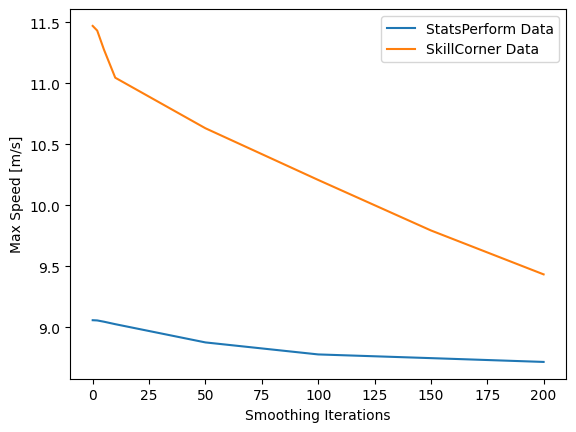

ValueError: Length of values (7) does not match length of index (3)

In [44]:
metrics = []
for df in smoothDataFrames:
    metrics.append(extractMetrics(df))

its = [
    0, 
    2,
    5, 
    10, 
    50, 
    100, 
    150, 
    200
]
    
maxSpeedList = list(map(lambda m: m['maxSpeed'], metrics))
maxSpeedListSkillCorner = [11.4715, 11.4333, 11.2768, 11.0467, 10.6320, 10.2081, 9.7938, 9.4333]
maxSpeedListStatsPerform = [9.0573, 9.0555, 9.0450, 9.0248, 8.8751, 8.7766, 8.7462, 8.7151]
plt.plot(its, maxSpeedListStatsPerform, label='StatsPerform Data')
plt.plot(its, maxSpeedListSkillCorner, label='SkillCorner Data')
plt.xlabel('Smoothing Iterations')  # Replace 'Index' with the actual x-axis label
plt.ylabel('Max Speed [m/s]')  # Replace 'Value' with the actual y-axis label  
plt.legend()
plt.show()
metrics = pd.DataFrame(metrics)
metrics['iterations'] = its[1:]
metrics = metrics[['iterations', 'maxSpeed', 'maximumSpeedSustained', 'sprintCount', 'distanceCovered']]
metrics